In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *
from pandas_helper import *

In [2]:
%matplotlib inline

In [3]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [4]:
datafolder = "C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_itf_output_data\\"
datafoldercity = "C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_itf_output_data\\per city\\"
datafolderold = "C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_itf_output_data\\old\\"

In [5]:
os.listdir(datafolder)

['country_data.csv',
 'Demand.csv',
 'GCAP.csv',
 'GDP.csv',
 'MetaData.docx',
 'old',
 'per city',
 'PT_infra.csv',
 'Road_infra.csv',
 'ScenarioVariable.csv',
 'wbccodes2014.csv']

In [6]:
os.listdir(datafoldercity)

['country_data.csv',
 'MetaData.docx',
 'PT_infra.csv',
 'PT_infra_city.csv',
 'Road_infra.csv',
 'Road_infra_city.csv',
 'ScenarioVariable.csv',
 'ScenarioVariable_city.csv']

# Load data

In [7]:
pt_infra_c = pd.read_csv(datafoldercity+"PT_infra_city.csv",encoding='latin-1')
road_infra_c = pd.read_csv(datafoldercity+"Road_infra_city.csv",encoding='latin-1')
scenario_c = pd.read_csv(datafoldercity+"ScenarioVariable_city.csv",encoding='latin-1')

In [8]:
demand = pd.read_csv(datafolder+"Demand.csv")
gcap_pop = pd.read_csv(datafolder+"GCAP.csv")
gdp = pd.read_csv(datafolder+"GDP.csv")

pt_infra = pd.read_csv(datafolder+"PT_infra.csv",encoding='latin-1')
#pt_infra = pd.read_csv(datafolderold+"PT_infra.csv",encoding='latin-1')

road_infra = pd.read_csv(datafolder+"Road_infra.csv",encoding='latin-1')
scenario = pd.read_csv(datafolder+"ScenarioVariable.csv",encoding='latin-1')

In [9]:
country_data = pd.read_csv(datafolder+"country_data.csv",encoding='latin-1')

In [10]:
pt_infra.columns

Index(['ISO3', 'SC', 'Year', 'infraPt', 'capitalCostBus', 'busVKM', 'ptVKM',
       'busEmiss', 'lighRail_BRTLength', 'undergroundRailLength', 'OM_infraPt',
       'OM_vehiclePt'],
      dtype='object')

In [11]:
country_data.columns

Index(['ISO3', 'Year', 'GDP_USD2010', 'GCAP_USD2010', 'CarOwn'], dtype='object')

In [12]:
scenario_c.columns

Index(['city_ID', 'SC', 'Year', 'ISO3', 'Income.group', 'POP', 'GCAP',
       'carPKM', 'motorPKM', 'ptPKM', 'walkPKM', 'cyclePKM', 'totTrip',
       'Density', 'city_name'],
      dtype='object')

In [13]:
scenario_c.set_index(["ISO3","SC","Year","city_ID"]).totTrip.sum(level=["SC"])

SC
BAU    2.294875e+13
ROG    2.294549e+13
LUT    2.294336e+13
Name: totTrip, dtype: float64

## merge data

In [14]:
all_c = scenario_c.merge(pt_infra_c,on=["ISO3","SC","Year","city_ID"]).merge(road_infra_c,on=["ISO3","SC","Year","city_ID"])

In [15]:
all_c["total_inv"] = all_c.infraPt+all_c.localroad_invest_billion+all_c.mainroad_invest_billion
all_c["GDP"] = all_c.GCAP*all_c.POP*1000
all_c["total_inv_over_gdp"] = 10**9*all_c.total_inv/all_c.GDP

In [16]:
new_index = pd.Index(np.arange(2010,2051))
new_index.name = "Year_all"

In [17]:
test = country_data.set_index(["ISO3"])

## interpolate GDP between the 5 years periods

In [18]:
newdata = test.loc[~test.GDP_USD2010.isnull(),:].copy()
newdata.loc[:,"GDP_USD2010"] = newdata.GDP_USD2010.astype(float)

In [19]:
gdp_year = newdata.set_index("Year",append=True).GDP_USD2010.unstack("Year").reindex(range(2010,2051),axis=1).interpolate(axis=1).stack("Year").to_frame().rename(columns={0:"GDP_USD2010"})

In [20]:
def f(x):
    x = x.reset_index()
    y = pd.DataFrame(columns=["Year","GDP_country_interp"])
    for year in [2015,2020,2025,2030,2035,2040,2045,2050]:
        y = y.append(pd.DataFrame([[round(year),x.loc[(x.Year<=year)&(x.Year>year-5),"GDP_USD2010"].sum()]],columns=["Year","GDP_country_interp"]),ignore_index=True)
    return y

In [21]:
new_gdp = gdp_year.groupby(level=["ISO3"]).apply(f)

In [22]:
new_gdp.reset_index().drop("level_1",axis=1).sample(3)

,ISO3,Year,GDP_country_interp
1466,VCT,2025,6.976957e+09
1102,PLW,2045,3.826141e+09
1384,TUN,2015,4.847417e+11


In [23]:
pt_infra.columns

Index(['ISO3', 'SC', 'Year', 'infraPt', 'capitalCostBus', 'busVKM', 'ptVKM',
       'busEmiss', 'lighRail_BRTLength', 'undergroundRailLength', 'OM_infraPt',
       'OM_vehiclePt'],
      dtype='object')

In [24]:
new_gdp = new_gdp.reset_index().drop("level_1",axis=1)
new_gdp["Year"] = new_gdp.Year.astype("int64")

In [25]:
all_v = scenario.merge(pt_infra,on=["ISO3","SC","Year"]).merge(road_infra,on=["ISO3","SC","Year"]).merge(new_gdp,on=["ISO3","Year"])

In [26]:
codes = pd.read_csv(datafolder+"wbccodes2014.csv")

In [27]:
all_c = all_c.reset_index().merge(codes.rename(columns={"country":"ISO3"}),on="ISO3",how="left")

In [28]:
all_v = all_v.reset_index().merge(codes.rename(columns={"country":"ISO3"}),on="ISO3",how="left")

In [29]:
all_v.columns

Index(['index', 'SC', 'Year', 'ISO3', 'Income.group', 'POP', 'GCAP', 'carPKM',
       'motorPKM', 'ptPKM', 'walkPKM', 'cyclePKM', 'totTrip', 'Density',
       'infraPt', 'capitalCostBus', 'busVKM', 'ptVKM', 'busEmiss',
       'lighRail_BRTLength', 'undergroundRailLength', 'OM_infraPt',
       'OM_vehiclePt', 'localroad_invest_billion', 'mainroad_invest_billion',
       'main_road', 'car_usage', 'car_capital_cost', 'carEmiss', 'local_rd',
       'road_OM_extra', 'road_OM_2015', 'CarVKM', 'GDP_country_interp',
       'country_name', 'wbregion', 'wbregionname', 'wbincome', 'wbincomename',
       'wblending', 'wbhipc'],
      dtype='object')

In [30]:
all_v.wbincome.unique()

array(['HIO', 'HIX', 'UMI', 'LMI', 'LIC'], dtype=object)

In [31]:
all_v = all_v.loc[all_v.Year<2035,:]

In [32]:
all_v = all_v.set_index(["ISO3","SC","Year","wbregion"])

In [33]:
all_v["total_inv"] = all_v.infraPt+all_v.capitalCostBus+all_v.localroad_invest_billion+all_v.mainroad_invest_billion
all_v["GDP_city"] = all_v.GCAP*all_v.POP*1000
all_v["total_inv_over_gdp_city"] = 10**9*all_v.total_inv/all_v.GDP_city
all_v["total_inv_over_gdp_country"] = 10**9*all_v.total_inv/all_v.GDP_country_interp

all_v["maintenance_over_gdp_country"] = 10**9*(all_v.road_OM_extra+all_v.road_OM_2015+all_v.OM_infraPt+all_v.OM_vehiclePt)/all_v.GDP_country_interp

all_v["public_transport_investments"] = all_v.infraPt+all_v.capitalCostBus
all_v["road_investments"] = all_v.localroad_invest_billion+all_v.mainroad_invest_billion
all_v["roads_maintenance"] = all_v.road_OM_extra+all_v.road_OM_2015

all_v["total_total"] = all_v["total_inv"]+all_v["roads_maintenance"]+all_v.OM_infraPt+all_v.OM_vehiclePt

all_v["total_maintenance"] = all_v["roads_maintenance"]+all_v.OM_infraPt+all_v.OM_vehiclePt

## Vietnam data

In [38]:
vtn = all_v.reset_index("ISO3")
vtn = vtn.loc[vtn.ISO3=="VNM"]

In [40]:
vtn.columns

Index(['ISO3', 'index', 'Income.group', 'POP', 'GCAP', 'carPKM', 'motorPKM',
       'ptPKM', 'walkPKM', 'cyclePKM', 'totTrip', 'Density', 'infraPt',
       'capitalCostBus', 'busVKM', 'ptVKM', 'busEmiss', 'lighRail_BRTLength',
       'undergroundRailLength', 'OM_infraPt', 'OM_vehiclePt',
       'localroad_invest_billion', 'mainroad_invest_billion', 'main_road',
       'car_usage', 'car_capital_cost', 'carEmiss', 'local_rd',
       'road_OM_extra', 'road_OM_2015', 'CarVKM', 'GDP_country_interp',
       'country_name', 'wbregionname', 'wbincome', 'wbincomename', 'wblending',
       'wbhipc', 'total_inv', 'GDP_city', 'total_inv_over_gdp_city',
       'total_inv_over_gdp_country', 'maintenance_over_gdp_country',
       'public_transport_investments', 'road_investments', 'roads_maintenance',
       'total_total', 'total_maintenance'],
      dtype='object')

In [46]:
vtn['public_transport_maintenance'] = vtn.OM_infraPt
vtn['GDP_5years'] = vtn.GDP_country_interp

In [44]:
vtn[['public_transport_investments',\
     'road_investments', 'roads_maintenance', 'public_transport_maintenance']].sum(axis=1)

SC   Year  wbregion
BAU  2015  EAP          3.888311
ROG  2015  EAP          3.878304
LUT  2015  EAP          3.884741
BAU  2020  EAP          8.510465
ROG  2020  EAP          8.550825
LUT  2020  EAP          8.551860
BAU  2025  EAP          6.984713
ROG  2025  EAP          8.639862
LUT  2025  EAP          6.107234
BAU  2030  EAP          9.388213
ROG  2030  EAP         12.418694
LUT  2030  EAP          9.114656
dtype: float64

In [48]:
vtn[['country_name','POP', 'GCAP','GDP_5years', 'totTrip','public_transport_investments',\
     'road_investments', 'roads_maintenance', 'public_transport_maintenance']].to_csv("Vietnam_urban_transport.csv")

In [49]:
vtn[['country_name','POP', 'GCAP','GDP_5years', 'totTrip','public_transport_investments',\
     'road_investments', 'roads_maintenance', 'public_transport_maintenance']]

,,,country_name,POP,GCAP,GDP_5years,totTrip,public_transport_investments,road_investments,roads_maintenance,public_transport_maintenance
SC,Year,wbregion,,,,,,,,,
BAU,2015,EAP,Vietnam,15981,13163.899266,1.475944e+12,1.369032e+10,0.775681,2.481743,0.629422,0.001466
ROG,2015,EAP,Vietnam,15981,13163.899266,1.475944e+12,1.369032e+10,0.777361,2.485284,0.614193,0.001466
LUT,2015,EAP,Vietnam,15981,13163.899266,1.475944e+12,1.369032e+10,0.777361,2.485284,0.620630,0.001466
BAU,2020,EAP,Vietnam,18624,16281.571554,1.913869e+12,1.636252e+10,4.493047,2.722666,0.894865,0.399887
ROG,2020,EAP,Vietnam,18624,16281.571554,1.913869e+12,1.636252e+10,4.596875,2.659048,0.885764,0.409138
LUT,2020,EAP,Vietnam,18624,16281.571554,1.913869e+12,1.636252e+10,4.596875,2.659048,0.886799,0.409138
BAU,2025,EAP,Vietnam,21018,19832.315753,2.470066e+12,1.899030e+10,2.336481,3.198787,0.983056,0.466389
ROG,2025,EAP,Vietnam,21018,19832.315753,2.470066e+12,1.899030e+10,4.256575,2.858971,0.942936,0.581380
LUT,2025,EAP,Vietnam,21018,19832.315753,2.470066e+12,1.899030e+10,4.089612,0.647500,0.800131,0.569991


In [69]:
all_v_s = all_v.sum(level=["SC","Year"])
all_v_s["total_inv_over_gdp_country"] = 10**9*all_v_s.total_inv/all_v_s.GDP_country_interp
all_v_s["maintenance_over_gdp_country"] = 10**9*(all_v_s.road_OM_extra+all_v_s.road_OM_2015+all_v_s.OM_infraPt+all_v_s.OM_vehiclePt)/all_v_s.GDP_country_interp
all_v_s["total_total_gdp_country"] = 10**9*all_v_s.total_total/all_v_s.GDP_country_interp

In [70]:
100*all_v_s.maintenance_over_gdp_country.mean(level="SC")

SC
BAU    1.253474
ROG    1.587235
LUT    1.575482
Name: maintenance_over_gdp_country, dtype: float64

### developing countries only

In [71]:
all_v_s_dev = all_v.reset_index().loc[all_v.reset_index().wbregion!='YHI',:].set_index(["ISO3","SC","Year","wbregion"]).sum(level=["SC","Year"])
all_v_s_dev["total_inv_over_gdp_country"] = 10**9*all_v_s_dev.total_inv/all_v_s_dev.GDP_country_interp
all_v_s_dev["OandM_over_gdp_country"] = 10**9*(all_v_s_dev.road_OM_extra+all_v_s_dev.road_OM_2015+all_v_s_dev.OM_infraPt+all_v_s_dev.OM_vehiclePt)/all_v_s_dev.GDP_country_interp
all_v_s_dev["total_total_gdp_country"] = 10**9*all_v_s_dev.total_total/all_v_s_dev.GDP_country_interp
all_v_s_dev["maintenance_over_gdp_country"] = 10**9*(all_v_s_dev.road_OM_extra+all_v_s_dev.road_OM_2015+all_v_s_dev.OM_infraPt)/all_v_s_dev.GDP_country_interp
all_v_s_dev["operations_over_gdp_country"] = 10**9*(all_v_s_dev.OM_vehiclePt)/all_v_s_dev.GDP_country_interp

In [75]:
100*all_v_s_dev.operations_over_gdp_country.mean(level="SC")

SC
BAU    0.992870
ROG    1.280880
LUT    1.268546
Name: operations_over_gdp_country, dtype: float64

In [76]:
100*all_v_s_dev.maintenance_over_gdp_country.mean(level="SC")

SC
BAU    0.208516
ROG    0.203835
LUT    0.195302
Name: maintenance_over_gdp_country, dtype: float64

In [77]:
100*all_v_s_dev.total_inv_over_gdp_country.mean(level="SC")

SC
BAU    0.454236
ROG    0.469477
LUT    0.371363
Name: total_inv_over_gdp_country, dtype: float64

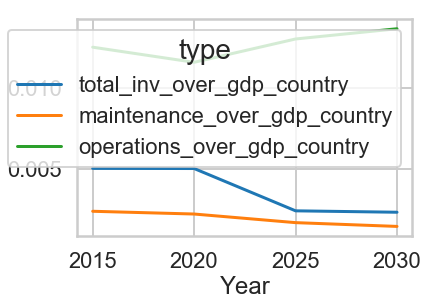

In [78]:
best_scenario = all_v_s_dev[["total_inv_over_gdp_country","maintenance_over_gdp_country","operations_over_gdp_country"]].copy()
best_scenario.columns.name="type"
best_scenario.stack().unstack("SC")["LUT"].unstack("type").plot()

In [79]:
all_v = all_v.reset_index().set_index(["ISO3","SC","Year","wbregion"])

### by region

In [81]:
all_v_r_s = all_v.sum(level=["SC","Year","wbregion"])
all_v_r_s["total_total_gdp_country"] = 10**9*all_v_r_s.total_total/all_v_r_s.GDP_country_interp
all_v_r_s["total_inv_over_gdp_country"] = 10**9*all_v_r_s.total_inv/all_v_r_s.GDP_country_interp
all_v_r_s["total_maint_over_gdp_country"] = 10**9*(all_v_r_s.road_OM_extra+all_v_r_s.road_OM_2015+all_v_r_s.OM_infraPt+all_v_r_s.OM_vehiclePt)/all_v_r_s.GDP_country_interp
all_v_r_s["total_road_maint_over_gdp_country"] = 10**9*(all_v_r_s.road_OM_extra+all_v_r_s.road_OM_2015)/all_v_r_s.GDP_country_interp
all_v_r_s["total_pt_maint_over_gdp_country"] = 10**9*(all_v_r_s.OM_infraPt)/all_v_r_s.GDP_country_interp
all_v_r_s["total_pt_ope_over_gdp_country"] = 10**9*(all_v_r_s.OM_vehiclePt)/all_v_r_s.GDP_country_interp

In [82]:
all_v_ir_s = all_v.reset_index().set_index(["ISO3","SC","Year","wbincomename"]).sum(level=["SC","Year","wbincomename"])
all_v_ir_s["total_total_gdp_country"] = 10**9*all_v_ir_s.total_total/all_v_ir_s.GDP_country_interp

In [84]:
100*all_v_r_s.total_inv_over_gdp_country.mean(level=["wbregion"])

wbregion
YHI    0.496040
EAP    0.400267
ECA    0.530189
MNA    0.568106
SAS    0.278999
SSA    0.435081
LAC    0.588598
Name: total_inv_over_gdp_country, dtype: float64

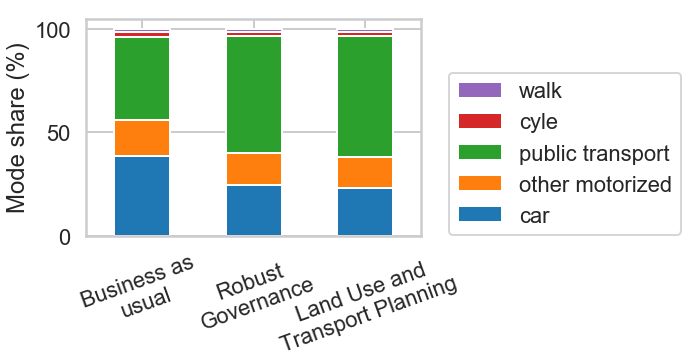

In [87]:
to_plot = (all_v_s_dev.reset_index().loc[all_v_s_dev.reset_index().Year==2030,["carPKM","motorPKM","ptPKM","cyclePKM","walkPKM","SC"]].set_index("SC"))
to_plot['total'] = to_plot.sum(axis=1)
to_plot = 100*to_plot.div(to_plot['total'],axis=0).drop("total",axis=1)
to_plot = to_plot.reset_index()

to_plot["SC"] = to_plot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
to_plot = to_plot.set_index("SC").sort_index(level="SC")
to_plot = to_plot.reset_index()

to_plot["SC"] = to_plot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

fig, ax1 = plt.subplots()
to_plot.set_index("SC")[["carPKM","motorPKM","ptPKM","cyclePKM","walkPKM"]].rename(columns={"carPKM":"car","motorPKM":"other motorized",\
                                                                                    "ptPKM":"public transport","cyclePKM":"cyle","walkPKM":"walk"}).plot(kind="bar",stacked=True,ax=ax1)
plt.xticks(rotation=20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.05, 0.8))
plt.xlabel("")
plt.ylabel("Mode share (%)")


#ax2 = ax1.twinx()
#to_plot.set_index("SC")["Access gain"].plot(kind="line",ax=ax2)
#ax2.grid(b=None)
#ax2.set_ylabel("Access gain")

plt.savefig("ITF_total_pkm_2030_pc_dev.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_pkm_2030_pc_dev.pdf")
plt.savefig("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 4\\fig4_6.eps")

In [88]:
to_plot.to_csv("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 4\\fig4_6.csv")

In [57]:
100*all_v_r_s[["total_road_maint_over_gdp_country","total_pt_maint_over_gdp_country"]].sum(axis=1).mean(level=["wbregion"])

wbregion
EAP    0.153279
ECA    0.347247
LAC    0.421917
MNA    0.248722
SAS    0.074200
SSA    0.137313
YHI    0.431601
dtype: float64

In [105]:
sns.set_context("poster",rc={"font.size": 20})
sns.set_style("whitegrid")

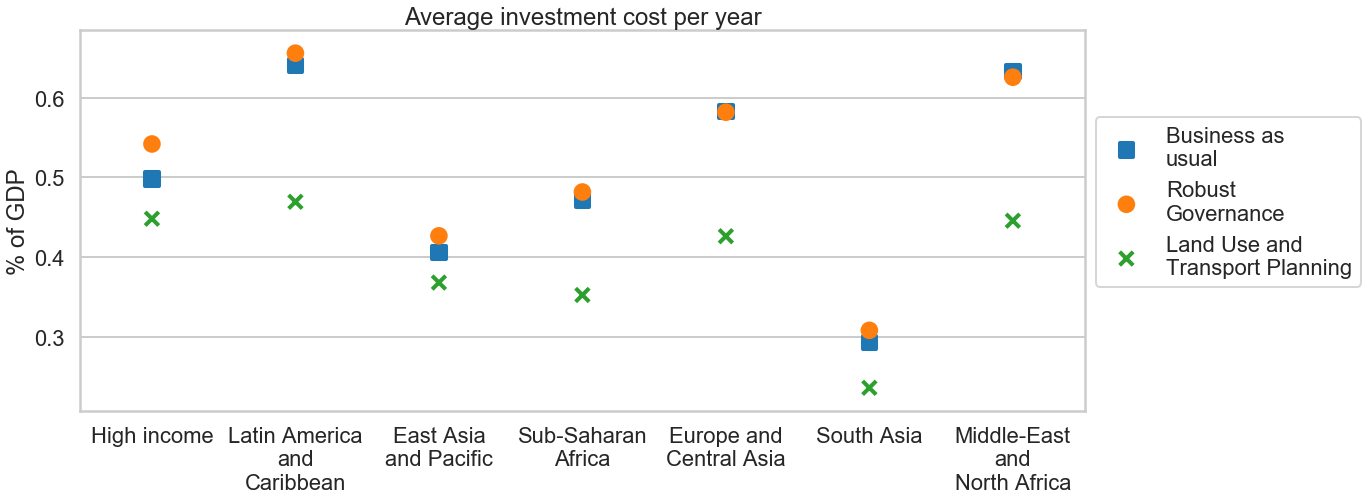

In [125]:
toplot = all_v_r_s.reset_index().set_index(["SC","wbregion","Year"])
toplot = toplot[["total_inv_over_gdp_country"]].mean(level=["SC","wbregion"]).reset_index()
toplot["SC"] = toplot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
toplot = toplot.set_index("SC").sort_index(level="SC")
toplot = toplot.reset_index()

toplot['wbregion'] = toplot.wbregion.replace({"EAP":"East Asia\nand Pacific",
                                             "ECA":"Europe and\nCentral Asia",
                                             "LAC":"Latin America\nand\nCaribbean",
                                             "MNA":"Middle-East\nand\nNorth Africa",
                                             "SAS":"South Asia",
                                             "SSA":"Sub-Saharan\nAfrica",
                                             "YHI":"High income"})
toplot["total_inv_over_gdp_country"] = 100*toplot.total_inv_over_gdp_country

toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

plt.figure(figsize=(18,7))

sns.pointplot(x="wbregion", y="total_inv_over_gdp_country",hue="SC", data=toplot, join=False, markers=["s","o","x"],)
plt.title("Average investment cost per year")
plt.ylabel("% of GDP")
#plt.ylim([0,0.035])
plt.xlabel("")
plt.legend(title="",bbox_to_anchor=(1., 0.8))

plt.savefig("ITF_total_inv_per_region_gdp_share.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_inv_per_region_gdp_share.pdf")

plt.savefig("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 4\\fig4_8.eps")
toplot.to_csv("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\chapter 4\\fig4_8.csv")

In [56]:
100*all_v_s_dev.operations_over_gdp_country.mean(level="SC")

SC
BAU    0.992870
LUT    1.268546
ROG    1.280880
Name: operations_over_gdp_country, dtype: float64

### Chiffre: All maintenance and operation costs

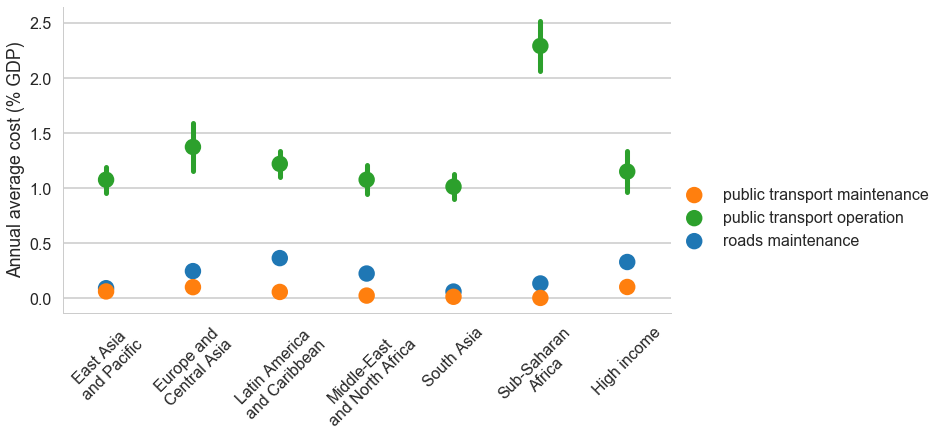

In [66]:
toplot = all_v_r_s.reset_index().set_index(["SC","wbregion","Year"])
toplot = toplot[["total_road_maint_over_gdp_country","total_pt_maint_over_gdp_country","total_pt_ope_over_gdp_country"]].mean(level=["SC","wbregion"])
toplot.columns.name = "capital_type"
toplot = toplot.stack()
toplot.name = 'value'
toplot = toplot.reset_index()

toplot = toplot.set_index("wbregion").sort_index(level="wbregion")
toplot = toplot.reset_index()

toplot['wbregion'] = toplot.wbregion.replace({"EAP":"East Asia\nand Pacific",
                                             "ECA":"Europe and\nCentral Asia",
                                             "LAC":"Latin America\nand Caribbean",
                                             "MNA":"Middle-East\nand North Africa",
                                             "SAS":"South Asia",
                                             "SSA":"Sub-Saharan\nAfrica",
                                             "YHI":"High income"})

toplot["capital_type"] = toplot.capital_type.replace({"total_road_maint_over_gdp_country":"roads maintenance",\
                                                          "total_pt_maint_over_gdp_country":"public transport maintenance",\
                                                     "total_pt_ope_over_gdp_country":"public transport operation"})

toplot['value']=100*toplot.value

#toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

g = sns.factorplot(x='wbregion',y='value',hue='capital_type',data=toplot, kind="point",dodge=False, size=6, aspect=1.7,\
                  legend=False, join=False, ci='sd')

g.set_axis_labels("", "Annual average cost (% GDP)")
g.add_legend(title="")
plt.xticks(rotation=45)

plt.savefig("ITF_maint_per_region_av.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_maint_per_region_av.pdf")

In [76]:
toplot.set_index(["wbregion","SC","capital_type"]).value.mean(level=["wbregion","capital_type"])

wbregion                       capital_type                
East Asia\nand Pacific         public transport maintenance    0.061914
                               public transport operation      1.076419
                               roads maintenance               0.091365
Europe and\nCentral Asia       public transport maintenance    0.100819
                               public transport operation      1.374259
                               roads maintenance               0.246428
High income                    public transport maintenance    0.102391
                               public transport operation      1.151028
                               roads maintenance               0.329210
Latin America\nand Caribbean   public transport maintenance    0.057310
                               public transport operation      1.220716
                               roads maintenance               0.364606
Middle-East\nand North Africa  public transport maintenance    0.024184
    

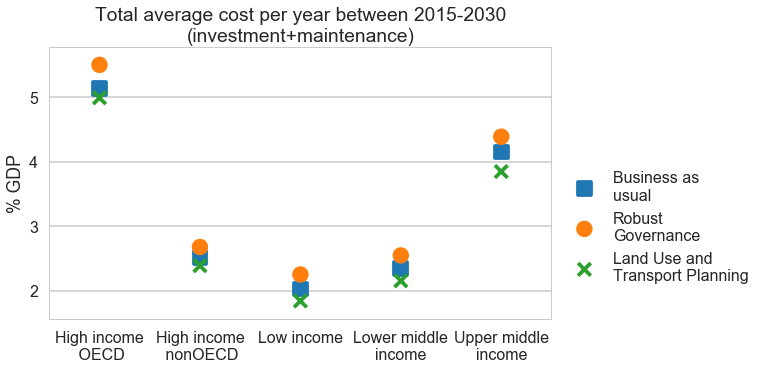

In [40]:
toplot = all_v_ir_s[["total_total_gdp_country"]].mean(level=["SC","wbincomename"]).reset_index()
toplot["wbincomename"]=toplot.wbincomename.str.replace(':','\n')
toplot["wbincomename"]=toplot.wbincomename.str.replace('middle ','middle\n')

toplot["SC"] = toplot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
toplot = toplot.set_index("SC").sort_index(level="SC")
toplot = toplot.reset_index()

toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

toplot["total_total_gdp_country"] = 100*toplot.total_total_gdp_country

plt.figure(figsize=(9,5))

ax1=sns.pointplot(x="wbincomename", y="total_total_gdp_country",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Total average cost per year between 2015-2030\n(investment+maintenance)")
plt.ylabel("% GDP")
plt.xlabel("")
plt.legend(title="",bbox_to_anchor=(1.005, 0.6))

plt.savefig("ITF_total_per_income_region.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_per_income_region.pdf")

In [367]:
all_v_r_s.total_inv_over_gdp_country.unstack("Year").drop([2035,2040,2045,2050],axis=1).mean(axis=1).unstack("SC")

SC,BAU,LUT,ROG
wbregion,,,
EAP,0.018103,0.016385,0.019050
ECA,0.028662,0.020998,0.028601
LAC,0.029932,0.021937,0.030648
MNA,0.029178,0.020685,0.028845
SAS,0.013052,0.010530,0.013744
SSA,0.020625,0.015276,0.020995
